# 导入包，读取数据

In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go 
import plotly.tools as tls
from xgboost import XGBRegressor
from tpot import TPOTRegressor

/usr/local/lib/python3.6/dist-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning:

Falling back to the python version of hypervolume module. Expect this to be very slow.

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/mpl_toolkits: missing __init__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/google: missing __init__



In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold, ShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import Imputer
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [3]:
py.init_notebook_mode(connected=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [31]:
# 读取数据， 改名
train = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
test.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
target_name = 'target'

# 存在异常数据，改为 nan
train.loc[1304, 'A25'] = np.nan
train['A25'] = train['A25'].astype(float)

# 去掉 id 前缀
train['id'] = train['id'].apply(lambda x: int(x.split('_')[1]))
test['id'] = test['id'].apply(lambda x: int(x.split('_')[1]))

# 原始数据观测

In [32]:
# 显示数据缺失率，最大类别占比

def show_data(pd_data, sort_target = 'Percentage of missing values'):
    stats = []
    for col in pd_data.columns:
        stats.append((col,
                      pd_data[col].nunique(),
                      pd_data[col].isnull().sum(),
                      pd_data[col].isnull().sum() * 100 / pd_data.shape[0],
                      pd_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      pd_data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature',
                                            'Unique_values',
                                            'missing number',
                                            'Percentage of missing values',
                                            'Percentage of values in the biggest category',
                                            'type'])
    
    return stats_df.sort_values(sort_target, ascending=False)

In [33]:
# show_data(train)[:10]

In [34]:
# show_data(test)[:10]

+ __删除收率异常值__

In [35]:
train.drop(train[train[target_name] < 0.87].index, inplace=True)
# train.drop(train[train['B14'] == 40].index, inplace=True)
n_train = train.shape[0]

In [36]:
full=pd.concat([train, test], ignore_index=True)
print(full.shape)
show_data(full)[:10]

(1533, 44)


,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
11,A2,1,1491,97.260274,97.260274,float64
26,A8,8,1366,89.106327,89.106327,float64
25,A7,79,1366,89.106327,89.106327,object
30,B11,39,925,60.339204,60.339204,object
29,B10,190,261,17.025440,17.025440,object
43,target,65,150,9.784736,19.895629,float64
21,A3,3,42,2.739726,96.086106,float64
28,B1,21,11,0.717547,54.403131,float64
13,A21,12,3,0.195695,89.889106,float64
15,A23,3,3,0.195695,99.673842,float64


# 数据清洗

## 删除缺失率高的特征

+ __删除缺失值大于 th_high 的值__
+ __缺失值在 th_low 和 th_high 之间的特征根据是否缺失增加新特征__
  
  如 B10 缺失较高，增加新特征 B10_null，如果缺失为1，否则为0

In [14]:
class del_nan_feature(BaseEstimator, TransformerMixin):
    
    def __init__(self, th_high=0.85, th_low=0.02):
        self.n_train = n_train
        self.th_high = th_high
        self.th_low = th_low
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'del_nan_feature', ' '*5, '-'*30, '\n')
        print("shape before process = {}".format(X.shape))

        # 删除高缺失率特征
        X.dropna(axis=1, thresh=(1-self.th_high)*X.shape[0], inplace=True)
        
        
        # 缺失率较高，增加新特征
        for col in X.columns:
            if col == 'target':
                continue
            
            miss_rate = X[col].isnull().sum()/ X.shape[0]
            if miss_rate > self.th_low:
                print("Missing rate of {} is {:.3f} exceed {}, adding new feature {}".
                     format(col, miss_rate, self.th_low, col+'_null'))
                X[col+'_null'] = 0
                X.loc[X[pd.isnull(X[col])].index, [col+'_null']] = 1
        print("shape = {}".format(X.shape))

        return X

In [15]:
pipe = Pipeline([('del_nan_feature', del_nan_feature())])
pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)
# show_data(pipe_data)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
(1532, 44)


## 处理字符时间（段）

In [16]:
# 处理时间
def timeTranSecond(t):
    try:
        h,m,s=t.split(":")
    except:

        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif pd.isnull(t):
            return np.nan
        else:
            return 0

    try:
        tm = (int(h)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600

    return tm

In [17]:
# 处理时间差
def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+",se)
#         print("sh, sm, eh, em = {}, {}, {}, {}".format(sh, em, eh, em))
    except:
        if pd.isnull(se):
            return np.nan, np.nan, np.nan

    try:
        t_start = (int(sh)*3600 + int(sm)*60)/3600
        t_end = (int(eh)*3600 + int(em)*60)/3600
        
        if t_start > t_end:
            tm = t_end - t_start + 24
        else:
            tm = t_end - t_start
    except:
        if se=='19:-20:05':
            return 19, 20, 1
        elif se=='15:00-1600':
            return 15, 16, 1
        else:
            print("se = {}".format(se))


    return t_start, t_end, tm

In [18]:
class handle_time_str(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'handle_time_str', ' '*5, '-'*30, '\n')

        for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
            try:
                X[f] = X[f].apply(timeTranSecond)
            except:
                print(f,'应该在前面被删除了！')


        for f in ['A20','A28','B4','B9','B10','B11']:
            try:
                start_end_diff = X[f].apply(getDuration)
                
                X[f+'_start'] = start_end_diff.apply(lambda x: x[0])
                X[f+'_end'] = start_end_diff.apply(lambda x: x[1])
                X[f] = start_end_diff.apply(lambda x: x[2])

            except:
                print(f,'应该在前面被删除了！')
        return X

In [19]:
pipe = Pipeline([
    ('del_nan_feature', del_nan_feature(0.85)),
    ('handle_time_str', handle_time_str()),
    ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
(1532, 56)


## 计算时间差

In [20]:
def t_start_t_end(t):
    if pd.isnull(t[0]) or pd.isnull(t[1]):
#         print("t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
        
    if t[1] < t[0]:
        t[1] += 24
        
    dt = t[1] - t[0]

    if(dt > 24 or dt < 0):
#         print("dt error, t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
    
    return dt

In [21]:
class calc_time_diff(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'calc_time_diff', ' '*5, '-'*30, '\n')

        # t_start 为时间的开始， tn 为中间的时间，减去 t_start 得到时间差
        t_start = ['A9', 'A24', 'B5']
        tn = {'A9':['A11', 'A14', 'A16'], 'A24':['A26'], 'B5':['B7']}
        
        # 计算时间差
        for t_s in t_start:
            for t_e in tn[t_s]:
                X[t_e+'-'+t_s] = X[[t_s,t_e, target_name]].apply(t_start_t_end, axis=1)
                
        # 所有结果保留 3 位小数
        X = X.apply(lambda x:round(x, 3))
        
        print("shape = {}".format(X.shape))
        
        return X

In [22]:
pipe = Pipeline([
    ('del_nan_feature', del_nan_feature()),
    ('handle_time_str', handle_time_str()),
    ('calc_time_diff', calc_time_diff())
    ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
------------------------------       calc_time_diff       ------------------------------ 

shape = (1532, 61)
(1532, 61)


## 处理异常值

In [23]:
class handle_outliers(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=2):
        # 处理单一类别个数小于 threshold 的值
        self.th = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'handle_outliers', ' '*5, '-'*30, '\n')
        category_col = [col for col in X if col not in ['id', 'target']]
        for col in category_col:
            label = X[col].value_counts(dropna=False).index.tolist()
            for i, num in enumerate(X[col].value_counts(dropna=False).values):
                if num <= self.th:
#                     print("Number of label {} in feature {} is {}".format(label[i], col, num))
                    X.loc[X[col]==label[i], [col]] = np.nan
        
        print("shape = {}".format(X.shape))
        return X

In [24]:
pipe = Pipeline([
                ('del_nan_feature', del_nan_feature(0.85)),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(2)),
                ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
------------------------------       calc_time_diff       ------------------------------ 

shape = (1532, 61)
------------------------------       handle_outliers       ------------------------------ 

shape = (1532, 61)
(1532, 61)


In [56]:
# show_data(pipe_data)

## 删除单一类别占比过大特征

In [26]:
class del_single_feature(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.98):
        # 删除单一类别占比大于 threshold 的特征
        self.th = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'del_single_feature', ' '*5, '-'*30, '\n')
        category_col = [col for col in X if col not in ['target']]
        
        for col in category_col:
            rate = X[col].value_counts(normalize=True, dropna=False).values[0]
            
            if rate > self.th:
                print("{} 的最大类别占比是 {}, drop it".format(col, rate))
                X.drop(col, axis=1, inplace=True)

        print("shape = {}".format(X.shape))
        return X

In [27]:
pipe = Pipeline([
                ('del_nan_feature', del_nan_feature(0.85)),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(2)),
                ('del_single_feature', del_single_feature(1)),
                ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
------------------------------       calc_time_diff       ------------------------------ 

shape = (1532, 61)
------------------------------       handle_outliers       ------------------------------ 

shape = (1532, 61)
------------------------------       del_single_feature       ------------------------------ 

shape = (1532, 61)
(1532, 61)


## 根据 B14 构建新特征

In [28]:
class add_new_features(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print('-'*30, ' '*5, 'add_new_features', ' '*5, '-'*30, '\n')

        # 经过测试,只有 B14 / B12 有用
        
#         X['B14/A1'] = X['B14'] / X['A1']
#         X['B14/A3'] = X['B14'] / X['A3']
#         X['B14/A4'] = X['B14'] / X['A4']
#         X['B14/A19'] = X['B14'] / X['A19']
#         X['B14/B1'] = X['B14'] / X['B1']
#         X['B14/B9'] = X['B14'] / X['B9']

        X['B14/B12'] = X['B14'] / X['B12']
        
        print("shape = {}".format(X.shape))
        return X

# 特征工程

## 通用画图程序

+ __画数据分布图__

In [5]:
def plt_cnt(df_data, idx):
    cnt = df_data[idx].value_counts(dropna=False).sort_index(ascending=True)
    plt.figure(figsize=(18,5))
    cnt.plot.bar()
    plt.title(idx)
    plt.show()
    return cnt

+ __画 A 与 B 的统计图__

In [6]:
def plt_A_B(df_data, idx_A, idx_B, bias):
    plt.figure(figsize=(18,5))
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

+ __画 A 与 B 的散点图__

In [7]:
def plt_point_A_B(df_data, idx_A, idx_B):
#     plt.figure(figsize=(18,5))
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))
#     plt.show()

## 获得训练集与测试集

In [32]:
def split_data(pipe_data, target_name='target'):
   
    # 特征列名
    category_col = [col for col in pipe_data if col not in ['target',target_name]]
    
    # 训练、测试行索引
    train_idx = pipe_data[np.logical_not(pd.isnull(pipe_data[target_name]))].index
    test_idx = pipe_data[pd.isnull(pipe_data[target_name])].index
    
    # 获得 train、test 数据
    X_train = pipe_data.loc[train_idx, category_col].values.astype(np.float64)
    y_train = np.squeeze(pipe_data.loc[train_idx, [target_name]].values.astype(np.float64))
    X_test = pipe_data.loc[test_idx, category_col].values.astype(np.float64)
    
    return X_train, y_train, X_test, test_idx

In [33]:
# X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
# X_train.shape, y_train.shape, X_test.shape, X_train.dtype, y_train.dtype, X_test.dtype

## xgb

In [34]:
##### xgb
def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=10, shuffle=True, random_state=2018)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

    if(verbose_eval):
        print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))
    return oof_xgb, predictions_xgb

## 选择特征, nan 值填充

+ __选择可能有效的特征__   (只是为了加快选择时间)

+ __利用其他特征预测 nan，取最近值填充__

In [35]:
def get_closest(indexes, predicts):
    print("From {}".format(predicts))

    for i, one in enumerate(predicts):
        predicts[i] = indexes[np.argsort(abs(indexes - one))[0]]

    print("To {}".format(predicts))
    return predicts
    

def value_select_eval(pipe_data, selected_features):
    
    # 经过多次测试, 只选择可能是有用的特征
    cols_with_nan = [col for col in pipe_data.columns 
                     if pipe_data[col].isnull().sum()>0 and col in selected_features]

    for col in cols_with_nan:
        X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name=col)
        oof_xgb, predictions_xgb = xgb_predict(X_train, y_train, X_test, verbose_eval=False)
        
        print("-"*100, end="\n\n")
        print("CV normal MAE scores of predicting {} is {}".
              format(col, mean_absolute_error(oof_xgb, y_train)/np.mean(y_train)))
        
        pipe_data.loc[test_idx, [col]] = get_closest(pipe_data[col].value_counts().index,
                                              predictions_xgb)

    pipe_data = pipe_data[selected_features+['target']]

    return pipe_data

# pipe_data = value_eval(pipe_data)

In [37]:
class selsected_fill_nans(BaseEstimator, TransformerMixin):

    def __init__(self, selected_features = ['A3_null', 'A6', 'A16', 'A25', 'A28', 'A28_end',
                                           'B5', 'B10_null', 'B11_null', 'B14', 'B14/B12', 'id']):
        self.selected_fearutes = selected_features
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'selsected_fill_nans', ' '*5, '-'*30, '\n')

        X = value_select_eval(X, self.selected_fearutes)

        print("shape = {}".format(X.shape))
        return X

## 后向选择特征

In [38]:
def modeling_cross_validation(data):
    X_train, y_train, X_test, test_idx = split_data(data,
                                                    target_name='target')
    oof_xgb, _ = xgb_predict(X_train, y_train, X_test, verbose_eval=False)
    print('-'*100, end='\n\n')
    return mean_squared_error(oof_xgb, y_train)


def featureSelect(data):

    init_cols = [f for f in data.columns if f not in ['target']]
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(data[best_cols+['target']])
    print("初始 CV score: {:<8.8f}".format(best_score))

    for col in init_cols:
        best_cols.remove(col)
        score = modeling_cross_validation(data[best_cols+['target']])
        print("当前选择特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}".
              format(col, score, best_score), end=" ")
        
        if best_score - score > 0.0000004:
            best_score = score
            print("有效果,删除！！！！")
        else:
            best_cols.append(col)
            print("保留")

    print('-'*100)
    print("优化后 CV score: {:<8.8f}".format(best_score))
    return best_cols, best_score

In [39]:
class select_feature(BaseEstimator, TransformerMixin):

    def __init__(self, init_features = None):
        self.init_features = init_features
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'select_feature', ' '*5, '-'*30, '\n')
        
        if self.init_features:
            X = X[self.init_features + ['target']]
            best_features = self.init_features
        else:
            best_features = [col for col in X.columns]
        
        last_feartues = []
        iteration = 0
        equal_time = 0
        
        best_CV = 1
        best_CV_feature = []
        
        # 打乱顺序,但是使用相同种子,保证每次运行结果相同
        np.random.seed(2018)
        while True:
            print("Iteration = {}\n".format(iteration))
            best_features, score = featureSelect(X[best_features + ['target']])
            
            # 保存最优 CV 的参数
            if score < best_CV:
                best_CV = score
                best_CV_feature = best_features
                print("Found best score :{}, with features :{}".format(best_CV, best_features))
                
            np.random.shuffle(best_features)
            print("\nCurrent fearure length = {}".format(len(best_features)))
            
            # 最终 3 次迭代相同，则终止迭代
            if len(best_features) == len(last_feartues):
                equal_time += 1
                if equal_time == 3:
                    break
            else:
                equal_time = 0selected_features = ['A3_null', 'A6', 'A16', 'A25', 'A28', 'A28_end', 
                     'B5', 'B10_null', 'B11_null', 'B14', 'B14/B12', 'id']

pipe = Pipeline([
                ('del_nan_feature', del_nan_feature()),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(2)),
                ('del_single_feature', del_single_feature(1)),
                ('add_new_features', add_new_features()),
                ('selsected_fill_nans', selsected_fill_nans(selected_features)),
                ('select_feature', select_feature(selected_features)),
                ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)
            
            last_feartues = best_features
            iteration = iteration + 1

            print("\n\n\n")
            
        return X[best_features + ['target']]


## 构建 pipeline, 处理数据

In [57]:
selected_features = ['A3_null', 'A6', 'A16', 'A25', 'A28', 'A28_end', 
                     'B5', 'B10_null', 'B11_null', 'B14', 'B14/B12', 'id']

pipe = Pipeline([
                ('del_nan_feature', del_nan_feature()),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(2)),
                ('del_single_feature', del_single_feature(1)),
                ('add_new_features', add_new_features()),
                ('selsected_fill_nans', selsected_fill_nans(selected_features)),
                ('select_feature', select_feature(selected_features)),
                ])

pipe_data = pipe.fit_transform(full.copy())
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
------------------------------       calc_time_diff       ------------------------------ 

shape = (1532, 61)
------------------------------       handle_outliers       ------------------------------ 

shape = (1532, 61)
------------------------------       del_single_feature       ------------------------------ 

shape = (1532, 61)
------------------------------       add_new_features       ------------------------------ 

shape = (1532, 62)
------------------------------       selsected_fill_nans       ------------------------------ 

----------------------------------------------------------------------------------------------------

当前选择特征: B14/B12, CV score: 0.00012291, 最佳cv score: 0.00011808 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A28_end, CV score: 0.00011717, 最佳cv score: 0.00011808 有效果,删除！！！！
----------------------------------------------------------------------------------------------------

当前选择特征: B5, CV score: 0.00011785, 最佳cv score: 0.00011717 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A6, CV score: 0.00012231, 最佳cv score: 0.00011717 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A16, CV score: 0.00011826, 最佳cv score: 0.00011717 保留
----------------------------------------------------------------------------------------------------

当前选择特征: B10_null, CV score: 0.00011966, 最佳cv score: 0.00011717 保留
---

----------------------------------------------------------------------------------------------------

当前选择特征: B14, CV score: 0.00012226, 最佳cv score: 0.00011747 保留
----------------------------------------------------------------------------------------------------
优化后 CV score: 0.00011747

Current fearure length = 8




Iteration = 6

----------------------------------------------------------------------------------------------------

初始 CV score: 0.00011715
----------------------------------------------------------------------------------------------------

当前选择特征: id, CV score: 0.00018398, 最佳cv score: 0.00011715 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A3_null, CV score: 0.00011984, 最佳cv score: 0.00011715 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A25, CV score: 0.00012132, 最佳cv score: 0.00011715 保留
----------------------------------------------

In [37]:
pipe_data[:2]

,B11_null,id,B14,A25,A6,B14/B12,B5,target
0,1,1528,400.0,75.0,38.0,0.500000,8.0,0.879
1,0,1698,400.0,80.0,29.0,0.333333,23.0,0.902


In [ ]:
pipe_data = pipe_data[['B5', 'id', 'B14/B12', 'A6', 'B10_null', 'B11_null', 'A25', 'A28', 'B14']+['target']]

## 处理后数据读取

In [ ]:
# pipe_data.to_csv('data/1195_13features.csv', index=0) 

## target 分箱

In [ ]:
def target_merge(data):
    
    categorical_columns = [f for f in data.columns if f not in ['id', 'target']]

    data = data.copy()
    for f in categorical_columns:
        data[f] = data[f].map(
            dict(zip(data[f].unique(), range(0, data[f].nunique()))))
    
    train = data[:n_train]
    test = data[n_train:].drop(['target'], axis=1)
    
    train['intTarget'] = pd.cut(train['target'], 5, labels=False)
    train = pd.get_dummies(train, columns=['intTarget'])
    li = ['intTarget_0','intTarget_1','intTarget_2','intTarget_3','intTarget_4']
    mean_columns = []
    for f1 in categorical_columns:
        cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
        if cate_rate < 0.90:
            for f2 in li:
                col_name = 'B14_to_'+f1+"_"+f2+'_mean'
                mean_columns.append(col_name)
                order_label = train.groupby([f1])[f2].mean()
#                 print("f1 = {}, f2 = {}, order_label = \n{}".format(f1, f2, order_label))
                train[col_name] = train['B14'].map(order_label)
                test[col_name] = test['B14'].map(order_label)
        
                miss_rate = test[col_name].isnull().sum() * 100 / test[col_name].shape[0]
                if miss_rate > 0:
                    print("miss_rate of {} to {} is {}".format(f1, f2, miss_rate))
                    print("f1 = {}, f2 = {}, order_label = \n{}".format(f1, f2, order_label))
                    train = train.drop([col_name], axis=1)
                    test = test.drop([col_name], axis=1)
                    mean_columns.remove(col_name)

    train.drop(li+['target'], axis=1, inplace=True)
    print(train.shape)
    print(test.shape)
    data = pd.concat([train, test]) 
    print(data.shape)
    return data, mean_columns

In [ ]:
# dummies_data, mean_columns = target_merge(pipe_data)
# dummies_data['target'] = pipe_data['target']

# 训练

## 画结果图

In [ ]:
def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.distplot(pred, bins=50, kde=False, color="red")
    plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)

    plt.show()
    plt.figure(figsize=(12,5))
    sns.distplot(truth, bins=50, kde=False, color="red")
    plt.title("Ground truth")
    plt.show()

## 单模型

### 多种模型测试

In [78]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    return mse

In [79]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [80]:
def model_test(X, y):
    names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
    for name, model in zip(names, models):
        score = mse_cv(model, X, y)
        print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))
        
model_test(X_train, y_train)

LR: 0.000412, 0.0001
Ridge: 0.000420, 0.0001
Lasso: 0.000552, 0.0001
RF: 0.000148, 0.0000
GBR: 0.000129, 0.0000
SVR: 0.000931, 0.0001
LinSVR: 0.002497, 0.0010
Ela: 0.000476, 0.0001
SGD: 223959444099909535929693372416.000000, 205287488345948350244167090176.0000
Bay: 0.000412, 0.0001
Ker: 0.000280, 0.0000
Extra: 0.000170, 0.0000
Xgb: 0.000134, 0.0000


### lgb

In [108]:
def lgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        lgb_param = {'num_leaves': 20, 'min_data_in_leaf': 2, 'objective':'regression', 'max_depth': 4,
         'learning_rate': 0.06, "min_child_samples": 3, "boosting": "gbdt", "feature_fraction": 1,
         "bagging_freq": 0.7, "bagging_fraction": 1, "bagging_seed": 11, "metric": 'mse', "lambda_l2": 0.003,
         "verbosity": -1}
    else :
        lgb_param = params
        
    folds = KFold(n_splits=10, shuffle=True, random_state=2018)
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if verbose_eval:
            print("fold n°{}".format(fold_+1))
            
        trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

        num_round = 10000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds = 100)
        
        oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

        if verbose_eval:
            print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))
    
    return oof_lgb, predictions_lgb

In [111]:
param_grid = [
        {'num_leaves': [20], 'min_data_in_leaf': [2, 3], 'objective':['regression'],
         'max_depth': [3, 4, 5], 'learning_rate': [0.06, 0.12, 0.24], "min_child_samples": [3],
         "boosting": ["gbdt"], "feature_fraction": [0.7], "bagging_freq": [1],
         "bagging_fraction": [1], "bagging_seed": [11], "metric": ['mse'],
         "lambda_l2": [0.0003, 0.001, 0.003], "verbosity": [-1]}
              ]

X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
best_score = 1

for params in ParameterGrid(param_grid):
    print('-'*100, "\nparams = \n{}\n".format(params))

    oof_xgb, predictions_xgb = lgb_predict(X_train, y_train, X_test, params=params, verbose_eval=False)
    score = mean_squared_error(oof_xgb, y_train)
    print("CV score: {}, current best score: {}".format(score, best_score))

    if best_score > score:
        print("Found new best score: {}".format(score))
        best_score = score
        lgb_best_params = params


print('\n\nbest params: {}'.format(lgb_best_params))
print('best score: {}'.format(best_score))

---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00011489364207207567, current best score: 1
Found new best score: 0.00011489364207207567
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00012002848815037457, current best score: 0.00011489364207207567
--------

CV score: 0.00011435307236140136, current best score: 0.00011231611613708764
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00012009711500307733, current best score: 0.00011231611613708764
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00011480005750940053,

CV score: 0.00012091648099518892, current best score: 0.00011212722352757958
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00011431927180539175, current best score: 0.00011212722352757958
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00012002843916496843, 

CV score: 0.000114353078699699, current best score: 0.00011212722352757958
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.003, 'learning_rate': 0.24, 'max_depth': 4, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.0001212472410367223, current best score: 0.00011212722352757958
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.003, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00011433021385951927, cur

In [137]:
X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
oof_lgb, predictions_lgb = lgb_predict(X_train, y_train, X_test, params=lgb_best_params, verbose_eval=200) #

fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[84]	training's l2: 7.64635e-05	valid_1's l2: 0.00013957
CV score: 0.76865147
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	training's l2: 8.03721e-05	valid_1's l2: 0.000110882
CV score: 0.68291002
fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 5.30193e-05	valid_1's l2: 0.000139552
Early stopping, best iteration is:
[173]	training's l2: 5.68838e-05	valid_1's l2: 0.000138392
CV score: 0.59707720
fold n°4
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 5.73108e-05	valid_1's l2: 0.000104267
Early stopping, best iteration is:
[104]	training's l2: 7.56046e-05	valid_1's l2: 9.52206e-05
CV score: 0.51161256
fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 5.36518e-05	valid_1's l2: 0.000110701
Early 

### xgb

In [139]:
param_grid = [
              {'silent': [1],
               'nthread': [4],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [4, 5, 6],
               'num_round': [1000],
               'subsample': [0.4, 0.6, 0.8, 1],
               'colsample_bytree': [0.7, 0.9, 1],
               }
              ]

X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
best_score = 1

for params in ParameterGrid(param_grid):
    print('-'*100, "\nparams = \n{}\n".format(params))

    oof_xgb, predictions_xgb = xgb_predict(X_train, y_train, X_test, params=params, verbose_eval=False)
    score = mean_squared_error(oof_xgb, y_train)
    print("CV score: {}, current best score: {}".format(score, best_score))

    if best_score > score:
        print("Found new best score: {}".format(score))
        best_score = score
        best_params = params


print('\n\nbest params: {}'.format(best_params))
print('best score: {}'.format(best_score))

---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}

CV score: 0.00011466648461334117, current best score: 1
Found new best score: 0.00011466648461334117
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}

CV score: 0.00011456634369353389, current best score: 0.00011466648461334117
Found new best score: 0.00011456634369353389
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_roun

CV score: 0.00011510995861245286, current best score: 0.00011350220852811235
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 6, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1}

CV score: 0.00011452153482808672, current best score: 0.00011350220852811235
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 1, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}

CV score: 0.00011658284174959551, current best score: 0.00011350220852811235
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 1, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_ro

In [141]:
X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
oof_xgb, predictions_xgb = xgb_predict(X_train, y_train, X_test, params=best_params, verbose_eval=200) #

fold n°1
len trn_idx  1244
[0]	train-rmse:0.41223	valid_data-rmse:0.414495
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.00937	valid_data-rmse:0.012154
[400]	train-rmse:0.00738	valid_data-rmse:0.012149
Stopping. Best iteration:
[249]	train-rmse:0.008639	valid_data-rmse:0.011963

fold n°2
len trn_idx  1244
[0]	train-rmse:0.412554	valid_data-rmse:0.411489
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[200]	train-rmse:0.009572	valid_data-rmse:0.010408
[400]	train-rmse:0.007492	valid_data-rmse:0.010257
Stopping. Best iteration:
[321]	train-rmse:0.008054	valid_data-rmse:0.010154

fold n°3
len trn_idx  1244
[0]	train-rmse:0.412511	valid_data-rmse:0.412077
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train 

## AutoML

In [ ]:
def auto_train(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=2018)

    tpot = TPOTRegressor(generations=100, population_size=20, verbosity=2, random_state=2018, warm_start=True)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('jinnan.py')

In [ ]:
# tpot = auto_train(X_train, y_train)

## 自动生成代码

In [100]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from tpot.builtins import StackingEstimator
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.kernel_approximation import Nystroem


def mode_pipeline(k = 0):
    if k == 0:
        # Average CV score on the training set was:-0.00017397577033911776
        exported_pipeline = make_pipeline(
            MinMaxScaler(),
            GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="huber", max_depth=6, max_features=0.5, min_samples_leaf=1, min_samples_split=17, n_estimators=100, subsample=0.8, random_state=2018)
        )
    elif k == 1:
        # Average CV score on the training set was:-0.0001868000824168013
        exported_pipeline = make_pipeline(
            StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.55, random_state=2018)),
            ExtraTreesRegressor(bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=5, min_samples_split=18, n_estimators=100, random_state=2018)
        )
    elif k == 2:
        # Average CV score on the training set was:-0.00011891000580359222
        exported_pipeline = make_pipeline(
            make_union(
                FunctionTransformer(copy),
                make_union(
                    StackingEstimator(estimator=make_pipeline(
                        Nystroem(gamma=0.8, kernel="poly", n_components=8),
                        LinearSVR(C=20.0, dual=False, epsilon=1.0, loss="squared_epsilon_insensitive", tol=0.1)
                    )),
                    FunctionTransformer(copy)
                )
            ),
            XGBRegressor(learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100, nthread=1, subsample=1.0)
        )
    else :
        # Average CV score on the training set was:-0.00018611148302895237
        exported_pipeline = make_pipeline(
            StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.35000000000000003, random_state=2018)),
            ExtraTreesRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=2018)
        )
        pass
    return exported_pipeline

def auto_predict(X_train, y_train, X_test, k=0):

    folds = KFold(n_splits=10, shuffle=True, random_state=2018)
    oof_auto = np.zeros(len(X_train))
    predictions_auto = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):


        training_features = X_train[trn_idx]
        testing_features = X_train[val_idx]

        training_target = y_train[trn_idx]
        testing_target = y_train[val_idx]
        
        exported_pipeline = mode_pipeline(k)
                
        exported_pipeline.fit(training_features, training_target)

        oof_auto[val_idx] = exported_pipeline.predict(testing_features)
        predictions_auto = exported_pipeline.predict(X_test) / folds.n_splits

        print("folds {}, CV score: {:<8.8f}".format(fold_, mean_squared_error(oof_auto[val_idx], testing_target)))
    
    print("CV score: {:<8.8f}".format(mean_squared_error(oof_auto, y_train)))
    return oof_auto, predictions_auto

In [142]:
X_train, y_train, X_test, test_idx = split_data(pipe_data, target_name='target')
oof_auto, predictions_auto = auto_predict(X_train, y_train, X_test, k=0)

folds 0, CV score: 0.00014612
folds 1, CV score: 0.00011121
folds 2, CV score: 0.00014796
folds 3, CV score: 0.00011250
folds 4, CV score: 0.00010489
folds 5, CV score: 0.00012033
folds 6, CV score: 0.00011330
folds 7, CV score: 0.00008239
folds 8, CV score: 0.00011745
folds 9, CV score: 0.00012840
CV score: 0.00011849


## 模型融合

In [153]:
# stacking
train_stack = np.vstack([oof_lgb, oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack, y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(y_train, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011094962448042872

# 提交结果

## B 榜提交

In [154]:
sub_df = pd.read_csv('data/jinnan_round1_testB_20190121.csv', encoding = 'gb18030')
sub_df = sub_df[['样本id', 'A1']]
sub_df['A1'] = predictions
sub_df['A1'] = sub_df['A1'].apply(lambda x:round(x, 3))
sub_df.to_csv('result/B_xgb_lgb.csv', header=0, index=0) 

## A榜提交

In [123]:
predictions = predictions
sub_df = pd.read_csv('data/jinnan_round1_testB_20190121.csv', header=None, encoding = 'gb18030')
sub_df["样本id"] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv('result/B_1117_8f_1.21.csv', header=0, index=0) 

ValueError: Length of values does not match length of index

# 对比结果差异

In [22]:
history = pd.read_csv('result/A/jinnan_round1_ansA_20190125.csv', encoding = 'gb18030', header=None)
current  = pd.read_csv('result/A/1133_7features_1.20.csv', encoding = 'gb18030', header=None)

current.rename(columns={0:'id', 1:'target'}, inplace = True)
history.rename(columns={0:'id', 1:'target'}, inplace = True)

current['id'] = current['id'].apply(lambda x: int(x.split('_')[1]))
history['id'] = history['id'].apply(lambda x: int(x.split('_')[1]))

current['C_H'] = current['target'] - history['target']

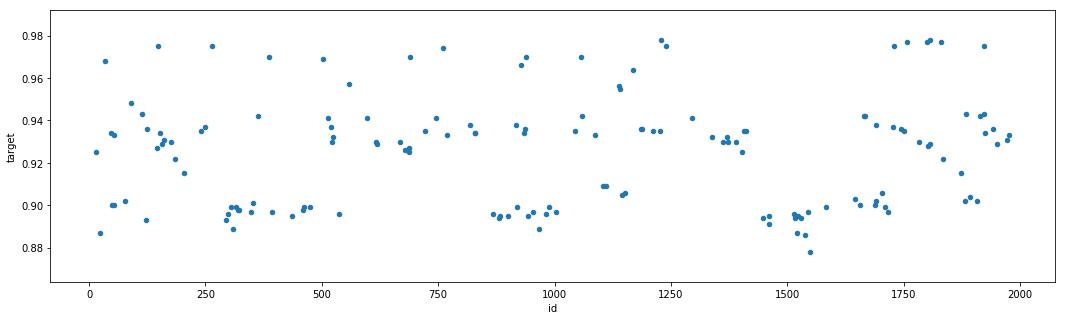

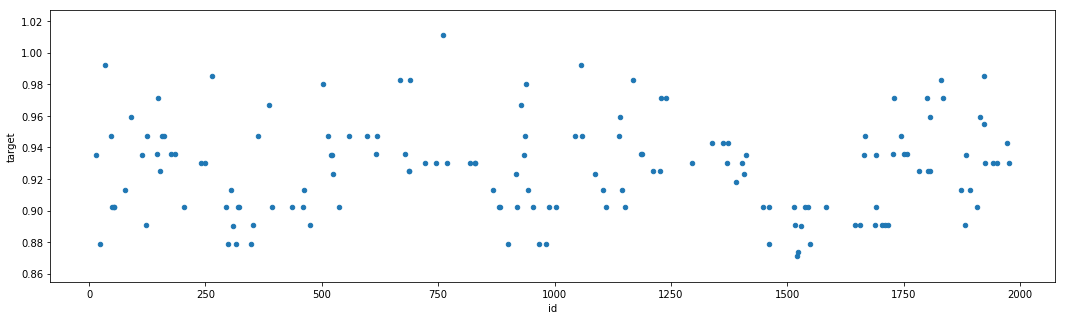

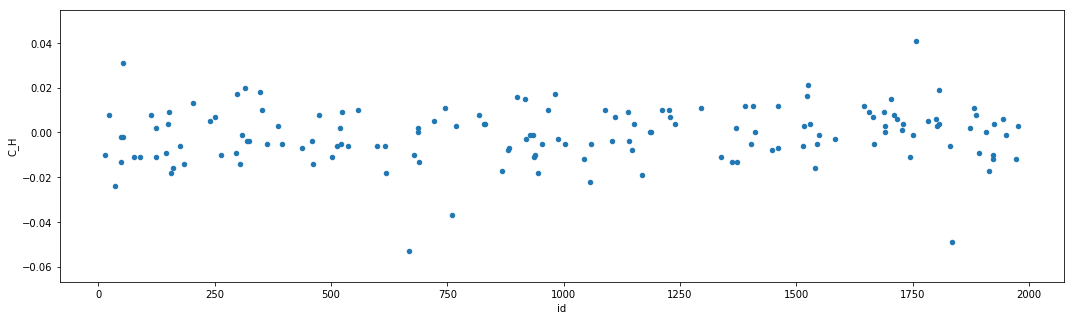

In [23]:
plt_point_A_B(current, 'id', 'target')
plt_point_A_B(history, 'id', 'target')
plt_point_A_B(current, 'id', 'C_H')

In [38]:
current.loc[np.abs(current['C_H']) > 0.02]

,id,target,C_H
15,1835,0.922,-0.049
37,316,0.899,0.020
57,1524,0.895,0.021
68,1057,0.970,-0.022
82,1757,0.977,0.041
110,761,0.974,-0.037
118,53,0.933,0.031
125,667,0.930,-0.053
129,35,0.968,-0.024


In [39]:
full[full['id'].apply(lambda x: x in current.loc[np.abs(current['C_H']) > 0.02, ['id']].values)]

,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A2,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A7,A8,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,id,target
1398,300,101,9:00:00,103.0,0.2,10:00:00,104.0,11:00:00,105.0,0.2,200,NaN,11:00-12:00,50.0,9.0,5.0,12:00:00,80.0,13:00:00,73.0,13:00-14:00,405.0,700,6:00:00,29.0,NaN,NaN,8:00:00,320.0,18:30-20:00,20:00-21:00,1200.0,0.15,400,3.5,3.5,14:00-15:00,15:00:00,80,17:00:00,45.0,17:00-18:30,1835,NaN
1420,300,100,19:10:00,102.0,0.2,20:10:00,103.0,21:10:00,102.0,0.2,300,NaN,1:30-2:00,50.0,9.0,5.0,2:00:00,70.0,2:30:00,75.0,10:30-11:00,405.0,700,16:00:00,32.0,16:20:00,80.0,18:10:00,300.0,19:30-21:00,NaN,800.0,0.15,785,3.5,3.5,11:00-13:00,13:00:00,50,17:00:00,28.0,17:00-18:00,316,NaN
1440,300,100,6:00:00,102.0,0.2,7:00:00,103.0,8:00:00,105.0,0.2,300,NaN,10:00-10:30,50.0,9.0,5.0,1:00:00,70.0,1:30:00,70.0,16:00-16:30,405.0,700,4:00:00,21.0,NaN,NaN,5:00:00,360.0,1:30-3:00,NaN,800.0,0.15,400,3.5,3.5,16:30-18:30,18:30:00,65,23:00:00,45.0,23:00-0:30,1524,NaN
1451,300,100,1:30:00,101.0,0.2,2:30:00,103.0,3:30:00,103.0,0.2,300,NaN,4:00-5:00,50.0,10.0,5.0,5:30:00,70.0,6:00:00,78.0,10:30-11:30,405.0,700,23:00:00,24.0,NaN,NaN,0:30:00,340.0,20:00-21:30,NaN,800.0,0.15,440,3.5,3.5,11:30-12:30,12:30:00,65,15:00:00,45.0,16；00-19:30,1057,NaN
1465,300,100,17:00:00,103.0,0.2,18:00:00,104.0,19:00:00,106.0,0.2,200,NaN,19:00-20:00,50.0,9.0,5.0,20:00:00,78.0,21:00:00,73.0,21:00-22:00,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,320.0,10:30-12:00,12:00-13:00,1200.0,0.15,420,3.5,3.5,6:00-7:00,7:00:00,78,9:00:00,45.0,9:00-10:30,1757,NaN
1493,300,102,20:30:00,103.0,0.2,21:30:00,104.0,22:30:00,105.0,0.2,200,NaN,NaN,50.0,9.0,5.0,23:00:00,80.0,0:00:00,73.0,0:00-1:00,405.0,700,17:30:00,29.0,NaN,NaN,19:30:00,320.0,NaN,NaN,1200.0,0.15,460,3.5,3.5,1:00-2:00,2:00:00,80,4:00:00,45.0,4:00-7:00,761,NaN
1501,300,100,20:00:00,104.0,0.2,21:00:00,106.0,22:00:00,106.0,0.2,300,NaN,22:30-23:00,50.0,9.0,5.0,23:00:00,70.0,0:00:00,77.0,0:00-1:00,405.0,700,18:00:00,18.0,NaN,NaN,19:00:00,350.0,5:30-7:00,NaN,400.0,0.15,400,3.5,3.5,1:00-2:00,2:00:00,68,3:30:00,45.0,3:30-5:00,53,NaN
1508,300,100,1:00:00,102.0,0.2,2:00:00,105.0,3:00:00,107.0,0.2,200,NaN,3:00-4:00,50.0,9.0,5.0,4:00:00,80.0,5:00:00,74.0,5:00-6:00,405.0,700,22:00:00,30.0,NaN,NaN,0:00:00,320.0,10:30-12:00,12:00-13:00,1200.0,0.15,400,3.5,3.5,6:00-7:00,7:00:00,80,9:00:00,45.0,9:00-10:30,667,NaN
1512,300,100,0:00:00,102.0,0.2,1:00:00,103.0,2:00:00,104.0,0.2,300,NaN,5:00-5:30,40.0,9.0,5.0,5:30:00,70.0,6:00:00,78.0,14:30-15:30,405.0,700,22:00:00,21.0,NaN,NaN,23:00:00,310.0,0:30-2:00,NaN,800.0,0.15,440,3.5,3.5,15:30-17:00,17:00:00,65,22:00:00,40.0,22:30-0:00,35,NaN


In [21]:
pipe_data[pipe_data['id'].apply(lambda x: x in current.loc[np.abs(current['C_H']) > 0.03, ['id']].values)]

NameError: name 'pipe_data' is not defined

# 日志

## 1-20

### 上午 11:27

+ __pipeline:__

('del_nan_feature', del_nan_feature()),

('handle_time_str', handle_time_str()),

('calc_time_diff', calc_time_diff()),

('Handle_outliers', handle_outliers(2)),

('del_single_feature', del_single_feature(1)),

('fill_nans', fill_nans()),

('select_feature', select_feature()),


+ __选择特征：__ 

初始 CV ： 13052

剩余特征 ： A6, A25, B5, B14, id, A3_null, B10_null, B11_null (8 个特征)

最后三次 CV ： 11770， 11917， 11942

+ __结果：__

xgb 默认参数 CV ： 11880

dummies（全部归0,1,2，B14 map）使用 xgb 默认参数 CV ： 12415

dummies（不规整，B14 map）使用 xgb 默认参数 CV ： 12059

dummies（不规整，自身 map）使用 xgb 默认参数 CV ： 12323

最终使用 pipe_data，最优 xgb 参数为：

{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5,
          'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1}
          
CV ： 11596

+ __线上：__ 7710

### 下午 18:18

+ __代码更新:__

修改程序 getDuration(se), 不仅计算时间差, 同时返回起始时间和终止时间

增加类 add_new_features, 构建新特征

+ __pipe_line:__

('del_nan_feature', del_nan_feature()),

('handle_time_str', handle_time_str()),

('calc_time_diff', calc_time_diff()),

('Handle_outliers', handle_outliers(2)),

('del_single_feature', del_single_feature(1)),

('fill_nans', fill_nans()),

('add_new_features', add_new_features()),

('select_feature', select_feature()),

+ __特征选择:__

初始 CV : 12879

剩余特征 ： A6, A16, A28, B14, B14/B12, B11_null, id (7 个特征)

最后三次 CV ： 11759， 11830， 11715


+ __结果：__

xgb 默认参数 CV ： 11855

dummies（全部归0,1,2，B14 map）使用 xgb 默认参数 CV ： 12442

dummies（不规整，B14 map）使用 xgb 默认参数 CV ： 11919

dummies（不规整，自身 map）使用 xgb 默认参数 CV ： 12447

最终使用 pipe_data，最优 xgb 参数为：

{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 4,
          'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.8}
          
CV ： 11332

+ __线上：__ 7697

## 1-21

### 上午 9:03

+ __说明:__ 只是重新跑了一遍

+ __pipe_line:__ 同上

+ __特征选择:__

初始 CV : 12879

剩余特征 ： A6, A28_end, B14, B14/B12, id (5 个特征)

最后三次 CV ： 11759， 11830， 11715


+ __结果：__

xgb 默认参数 CV ： 12099

最优 xgb 参数为：

{'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 4,
        'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.8}
          
CV ： 11486

+ __线上：__ 

### 上午 10:40

+ __更改代码:__

更改 pipeline 顺序,详见 pipeline

原 fill_nans 改为 selestcd_fill_nans, 增加预先选择的特征, 只填充预先选择的特征, 删除其他特征

更改 _后向选择特征_ , 增加预先选择特征, 增加随机种子, 保证每次结果相同

+ __pipeline:__

        ('del_nan_feature', del_nan_feature()),
        ('handle_time_str', handle_time_str()),
        ('calc_time_diff', calc_time_diff()),
        ('Handle_outliers', handle_outliers(2)),
        ('del_single_feature', del_single_feature(1)),
        ('add_new_features', add_new_features()),
        ('selsected_fill_nans', selsected_fill_nans(selected_features)),
        ('select_feature', select_feature(selected_features)),
        
其中 selected_features 为: 'A3_null', 'A6', 'A16', 'A25', 'A28', 'A28_end', 'B5', 'B10_null', 'B11_null', 'B14', 'B14/B12', 'id'

+ __特征选择:__ 

初始 CV : 12029

剩余特征 : A6, B5, B10_null, B14/B12, id  (5 个特征)

最后三次 CV: 11924, 11943, 12064

+ __结果:__

最优 xgb 参数: {'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1}

最优 xgb CV : 11536

### 下午 3:34

+ __更改代码:__

选择特征设定阈值为 0.0000004

+ __pipeline:__ 同上

+ __特征选择:__ 'A6', 'id', 'B14', 'A25', 'B14/B12', 'B11_null', 'A16'(7个)

最后三次 CV : 11776, 11939, 11853

+ __结果:__

最优 xgb 参数: {'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1}

best score: 11525

### 下午 5:17

+ __说明:__ 同上pipeline, 使用 10 折 xgb lgb 和 auto(0), 进行 stack, 得到 11292

# B榜  1-21 晚上 7 点

+ __特征选择:__

最终参数: id, A3_null, A25, B14/B12, B10_null, A16, A6, B14(8个特征)

最后三次 CV : 11747, 11715, 11709

+ __结果:__

lgb(10折,归一化): 

    最优参数: {'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.12, 'max_depth': 4, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

    结果: 1121
    
xgb(10折,归一化): 

    最优参数: {'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}

两个个融合: 11095

+ __发现问题:__

使用 auto_predict(0) 得到结果为 11849, 与 lgb 和 xgb 融合后结果有错, 生成的测试集几乎全部是 0.9 一下
